In [15]:
import h5py, sys, csv, time, os, datetime, math
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import KFold
import torch.nn as nn
from torch.optim import SGD
from copy import deepcopy
import numpy as np
from sklearn.metrics import roc_curve, f1_score, accuracy_score, auc
import matplotlib.pyplot as plt
from reading_util import filter_unwanted_esm2, H5Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from bootstrapping import bootstrap_statistic
from bootstrapping import calculate_f1, round_to_significance

In [16]:
# Custom Dataset
class EnzymeDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.data[idx]).float(), torch.FloatTensor([self.labels[idx]]).float()

In [17]:
def load_ml_data_emb(path_to_esm2: str, path_to_enzyme_csv: str):
    """
    Reads in the embeddings and the EC numbers from the h5 file and the csv file and labels them accordingly.
    :param path_to_esm2: path to the h5 file
    :param path_to_enzyme_csv: path to the csv file
    :return: X: embeddings, y: EC numbers (labels)
    """

    to_remove = filter_unwanted_esm2(path_to_enzyme_csv, True)

    h5_dataset = H5Dataset(path_to_esm2, path_to_enzyme_csv)

    loader = torch.utils.data.DataLoader(h5_dataset, batch_size=32, shuffle=False)

    # Iterate over batches
    X = []
    y = []

    t0 = time.time()
    for batch in loader:
        emb, header, ec_numbers = batch
        if header not in to_remove:

            ec_class = [int(ec_number.split(".")[0]) for ec_number in ec_numbers]  # here we convert ec to int and do -1
            X.append(emb.numpy())
            y.extend(list(ec_class))

    # Convert the lists to numpy arrays
    X = np.vstack(X)
    y = np.array(y)

    t1 = time.time()

    total = (t1 - t0) / 60

    print(f"LOG: Data loaded in: {round(total, 3)} min")
    print(f"LOG: ESM2 of enzymes: {len(X)}")
    print(f"LOG: Labels of enzymes: {len(y)}")

    return X, y

enzyme_sequences, enzyme_labels = load_ml_data_emb("D:/Uni/PBL/RNN/Dataset/split30_esm2_3b.h5", 'D:/Uni/PBL/RNN/Dataset/split30.csv')
dataset = EnzymeDataset(enzyme_sequences, enzyme_labels)

LOG: 3 Sequences with aa O in D:/Uni/PBL/RNN/Dataset/split30.csv
LOG: 15 Sequences with aa U in D:/Uni/PBL/RNN/Dataset/split30.csv
LOG: 203 multifunctional enzymes with diff ec main classes in D:/Uni/PBL/RNN/Dataset/split30.csv
LOG: 221 entries will be ignored
LOG: Data loaded in: 0.96 min
LOG: ESM2 of enzymes: 9204
LOG: Labels of enzymes: 9204


In [18]:
class EnzymeClassifiers(nn.Module):
    def __init__(self, input_dim, num_classes=7):
        super(EnzymeClassifiers, self).__init__()
        self.models = nn.ModuleList([FNN(input_dim) for _ in range(num_classes)])

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return outputs

In [19]:
class FNN(nn.Module):
    def __init__(self, input_dim):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1760)
        self.fc2 = nn.Linear(1760, 1000)
        self.fc3 = nn.Linear(1000, 500)
        self.fc4 = nn.Linear(500, 1)  # Binary classification output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

In [20]:
# Training function
def train_one_epoch(enzyme_class, model, dataloader, criterion, optimizer):
    '''
    model.train()
    running_loss = 0.0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct_predictions = (outputs.round() == labels).float().sum()
        accuracy = correct_predictions / labels.size(0)
    return loss.item(), accuracy.item()
    '''
    
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for data, labels in dataloader:       
        # Transfer data and labels to GPU
        data, labels = data.cuda(), labels.cuda()
        # Forward pass
        outputs = model(data)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        
        # Compute accuracy
        correct_predictions = (outputs.round() == labels).float().sum()
        total_correct += correct_predictions.item()
        total_samples += labels.size(0)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate average loss and accuracy
    average_loss = total_loss / len(train_loader)
    average_accuracy = total_correct / total_samples

    return average_loss, average_accuracy
    
# Validation function
def validate(enzyme_class, model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()
            
            # Compute accuracy
            correct_predictions = (outputs.round() == labels).float().sum()
            total_correct += correct_predictions.item()
            total_samples += labels.size(0)
            all_labels.append(labels)
            all_pred.append(outputs)
            
    
    
    # Calculate average loss and accuracy
    average_loss = val_loss / len(dataloader)
    average_accuracy = total_correct / total_samples

    return average_loss, average_accuracy, all_labels, all_pred


In [21]:
def generate_unique_filename(base_name: str, extension: str=".pt") -> str:
    """
    Generate a unique filename by appending current date-time.
    
    :param base_name: Base name for the file
    :param extension: Extension for the file. Default is ".pth"
    
    :return: A unique filename
    """
    current_time = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
    unique_name = f"{base_name}_{current_time}{extension}"
    
    # Check if filename already exists, although it's unlikely due to date-time precision
    while os.path.exists(unique_name):
        current_time = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        unique_name = f"{base_name}_{current_time}{extension}"
    
    return unique_name

In [22]:
models = []
lr = 0.007
epochs = 30
kf = KFold(n_splits=5)
enzyme_classifier = EnzymeClassifiers(2560).cuda().float()
patience = 5
all_labels = [[],[],[],[],[],[],[]]
all_pred =  [[],[],[],[],[],[],[]]


for enzyme_class in range(1, 8):
    print(f"Training for enzyme class {enzyme_class}")
    binary_labels = [1 if label == enzyme_class else 0 for label in enzyme_labels]
    dataset = EnzymeDataset(enzyme_sequences, binary_labels)
    current_model = enzyme_classifier.models[enzyme_class-1]
    criterion = nn.BCELoss()
    optimizer = SGD(current_model.parameters(), lr=lr)
    best_model_for_class = None
    best_val_loss = float('inf')
    no_improve_count = 0  # Initialize the counter for early stopping

    for train_idx, val_idx in kf.split(dataset):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
        train_loader = DataLoader(dataset, batch_size=32, sampler=train_subsampler)
        val_loader = DataLoader(dataset, batch_size=32, sampler=val_subsampler)
        for epoch in range(epochs):
            train_loss, train_accuracy = train_one_epoch(enzyme_class, current_model, train_loader, criterion, optimizer)
            val_loss, val_accuracy, all_labels[enzyme_class-1], all_pred[enzyme_class-1] = validate(enzyme_class, current_model, val_loader, criterion)

            '''# Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improve_count = 0  # Reset counter
                best_model_for_class = deepcopy(current_model)
            else:
                no_improve_count += 1'''
            best_model_for_class = deepcopy(current_model)
            print(f"Fold [{train_idx[0]+1}/{kf.get_n_splits()}] - Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

            overfitting_metric = train_accuracy - val_accuracy
            SOME_THRESHOLD = 0.1  
            if overfitting_metric > SOME_THRESHOLD:
                print(f"Warning: Model might be overfitting. Gap: {overfitting_metric:.4f}")

            '''if no_improve_count >= patience:
                print("Early stopping due to no improvement in validation loss for 5 consecutive epochs.")
                break  # Break out of the training loop for this fold'''
        """   
        # Optionally, you can reset the no_improve_count for each new fold
        no_improve_count = 0
        """
    models.append(best_model_for_class)
    
# Save models
unique_filename = generate_unique_filename("all_enzyme_classifiers")
torch.save(enzyme_classifier.state_dict(), unique_filename)
print(f"All models saved in {unique_filename}")

Training for enzyme class 1
Fold [1842/5] - Epoch 1/30 - Train Loss: 0.4866, Train Accuracy: 0.8643, Validation Loss: 0.4073, Validation Accuracy: 0.8577
Fold [1842/5] - Epoch 2/30 - Train Loss: 0.3853, Train Accuracy: 0.8688, Validation Loss: 0.4054, Validation Accuracy: 0.8577
Fold [1842/5] - Epoch 3/30 - Train Loss: 0.3846, Train Accuracy: 0.8688, Validation Loss: 0.4042, Validation Accuracy: 0.8577
Fold [1842/5] - Epoch 4/30 - Train Loss: 0.3870, Train Accuracy: 0.8688, Validation Loss: 0.4058, Validation Accuracy: 0.8577
Fold [1842/5] - Epoch 5/30 - Train Loss: 0.3868, Train Accuracy: 0.8688, Validation Loss: 0.4059, Validation Accuracy: 0.8577
Fold [1842/5] - Epoch 6/30 - Train Loss: 0.3887, Train Accuracy: 0.8688, Validation Loss: 0.4050, Validation Accuracy: 0.8577
Fold [1842/5] - Epoch 7/30 - Train Loss: 0.3834, Train Accuracy: 0.8688, Validation Loss: 0.4077, Validation Accuracy: 0.8577
Fold [1842/5] - Epoch 8/30 - Train Loss: 0.3857, Train Accuracy: 0.8688, Validation Loss: 

In [23]:
def predict(model, dataloader):
    model.eval()
    all_outputs = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.cuda()
            outputs = model(inputs).squeeze().cpu().numpy()  # Ensure that we're flattening the output
            all_outputs.extend(outputs)
    return all_outputs

F1 Score: 0.4409
Accuracy: 0.5185


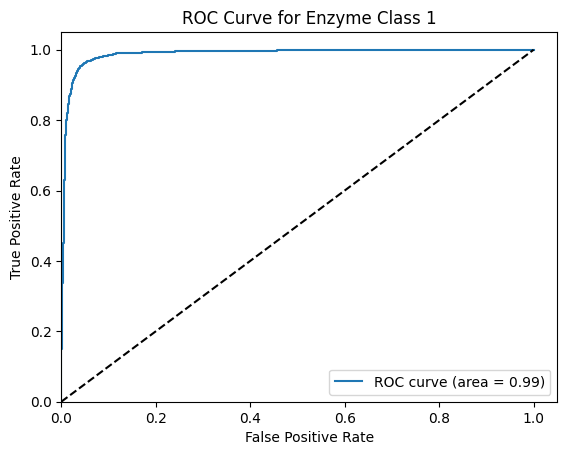

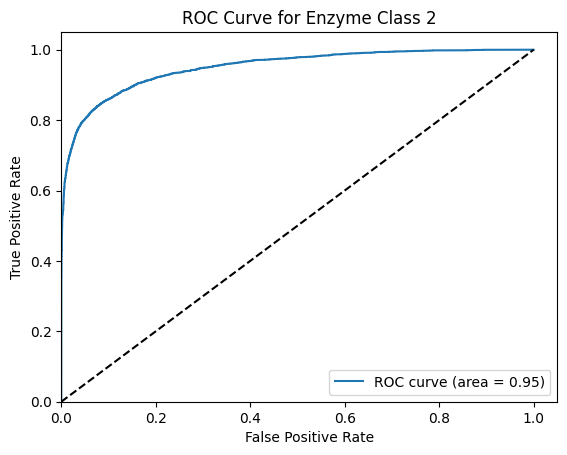

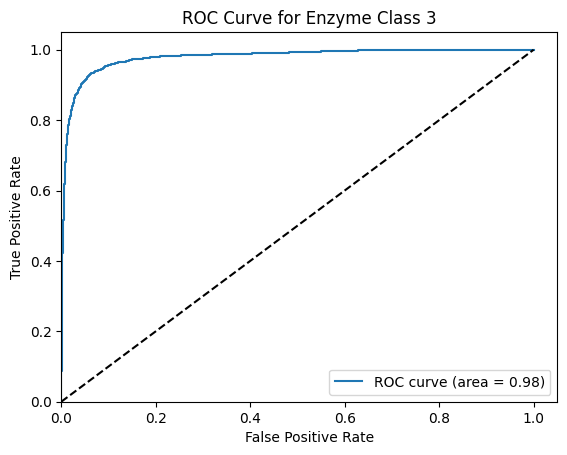

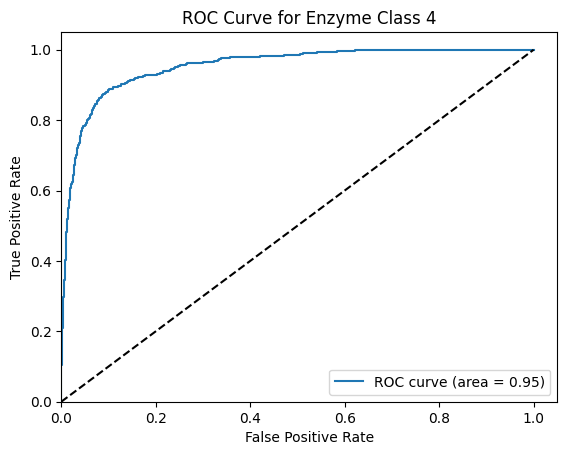

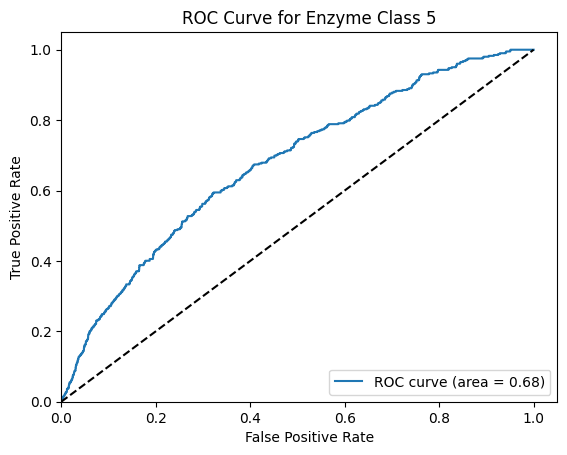

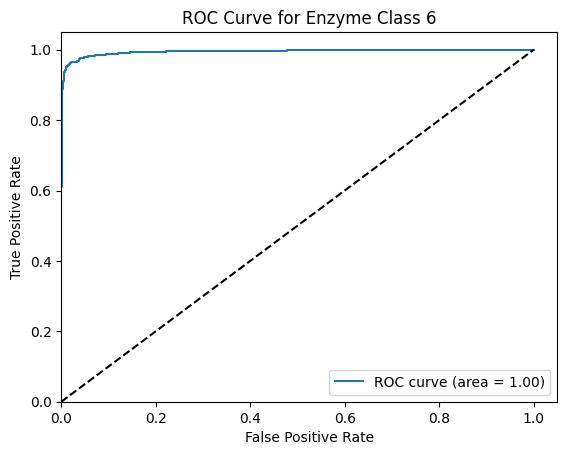

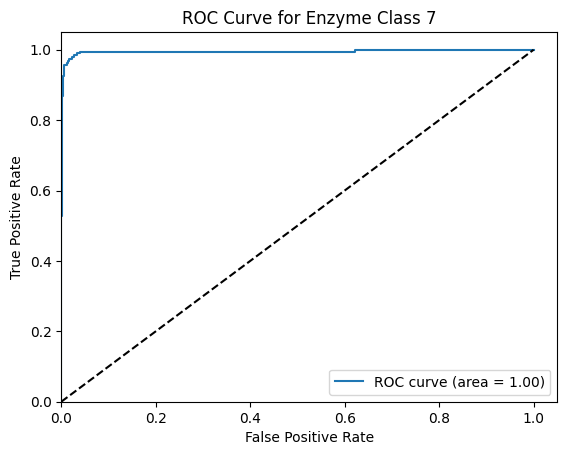

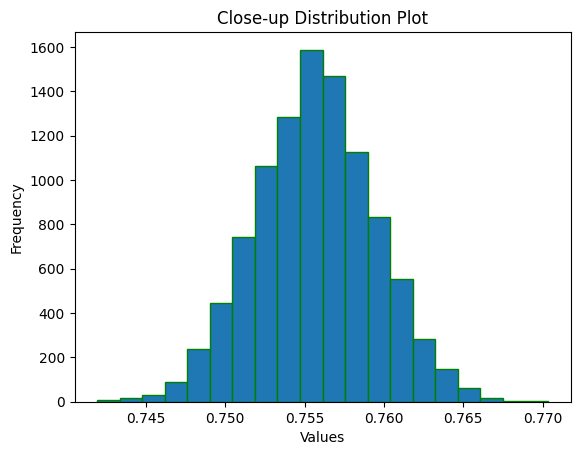

  - Initial F1 Score: 0.76
  - Mean ± SE: 0.756 ± 0.0038
  - 95% CI: [0.75, 0.76]


In [24]:
from itertools import chain

dataset = EnzymeDataset(enzyme_sequences, enzyme_labels)
loader = DataLoader(dataset, batch_size=32, shuffle=False)
all_scores = []

# Predict scores for each class using trained models
for model in models:
    scores = predict(model, loader)
    all_scores.append(scores)

# Transpose to have scores per instance rather than per class
all_scores = list(zip(*all_scores))

# Assign the enzyme class based on the highest score
predicted_classes = [scores.index(max(scores)) + 1 for scores in all_scores]

# Metrics: F1 Score and Accuracy
f1 = f1_score(enzyme_labels, predicted_classes, average='weighted')
accuracy = accuracy_score(enzyme_labels, predicted_classes)

print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# ROC curve
fpr = {}
tpr = {}
roc_auc = {}

for i, model in enumerate(models):
    scores = [score[i] for score in all_scores]  # Get scores for the i-th class across all samples
    binary_labels = [1 if label == i+1 else 0 for label in enzyme_labels]  # Create binary labels for the current class
    fpr[i], tpr[i], _ = roc_curve(binary_labels, scores)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plotting
    fig, ax = plt.subplots()
    ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.05])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for Enzyme Class {i+1}')
    ax.legend(loc="lower right")
    plt.savefig("D:/Uni/PBL/RNN/roc"+str(i+1)+".png")
    plt.show()
    
    plt.close('all')

all_labels2 = np.array([int(x) for x in list(chain.from_iterable(list(chain.from_iterable([x.tolist() for x in list(chain.from_iterable(all_labels))]))))])
all_pred2 = np.array([round(x) for x in list(chain.from_iterable(list(chain.from_iterable([x.tolist() for x in list(chain.from_iterable(all_pred))]))))])


def bootstrap_statistic(y_true, y_pred, statistic_func, B=10_000, alpha=0.05):
    bootstrap_scores = []
    for _ in range(B):
        indices = np.random.choice(len(y_pred), len(y_pred), replace=True)
        resampled_pred = y_pred[indices]
        resampled_true = y_true[indices]
        score = statistic_func(resampled_true, resampled_pred)
        bootstrap_scores.append(score)
        

    mean_score = np.mean(bootstrap_scores)
    standard_error = np.std(bootstrap_scores, ddof=1)

    # Calculate the 95% confidence interval
    lower_bound = np.percentile(bootstrap_scores, (alpha / 2) * 100)
    upper_bound = np.percentile(bootstrap_scores, (1 - alpha / 2) * 100)

    return mean_score, standard_error, (lower_bound, upper_bound), bootstrap_scores

mean_score, standard_error, bounds, bootstrap_scores = bootstrap_statistic(all_labels2, all_pred2, calculate_f1)


# Set the range of values you want to plot (e.g., between 0.70 and 0.74)
min_value = 0.70
max_value = 0.85

# Filter data within the specified range
filtered_data = [x for x in bootstrap_scores if min_value <= x <= max_value]

# Create the histogram
plt.hist(filtered_data, bins=20, edgecolor='green')

# Set the title and labels
plt.title('Close-up Distribution Plot')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Show the plot
plt.show()


initial_f1 = calculate_f1(all_labels2, all_pred2)
rounded_mean_f1, rounded_se_f1 = round_to_significance(mean_score, standard_error)
print(f"  - Initial F1 Score: {initial_f1:.2f}")
print(f"  - Mean ± SE: {rounded_mean_f1} ± {rounded_se_f1}")
print(f"  - 95% CI: [{bounds[0]:.2f}, {bounds[1]:.2f}]")